In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [17]:
data = 'dataset/df_cleaned.csv'
index_col = 0
df = pd.read_csv(data, sep=',', index_col=index_col)

pd.set_option('display.max_columns', None)

In [18]:
df['gender'] = df['gender'].astype('category')
df['nationality'] = df['nationality'].astype('category')
df['country'] = df['country'].astype('category')
df['region'] = df['region'].astype('category')
df['province'] = df['province'].astype('category')
df['birth_place'] = df['birth_place'].astype('category')
df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
df['active_start'] = pd.to_datetime(df['active_start'], errors='coerce')
df['description'] = df['description'].astype('string')


In [19]:
df['id_artist'] = df['id_artist'].astype('category')
df['id_album'] = df['id_album'].astype('category')
df['language'] = df['language'].astype('category')
df['album_type'] = df['album_type'].astype('category')
df['popularity'] = pd.to_numeric(df['popularity'], errors = 'coerce').astype('Int64')
df['n_sentences'] = df['n_sentences'].astype('Int64')
df['n_tokens'] = df['n_tokens'].astype('Int64')
df['disc_number'] = df['disc_number'].astype('Int64')
df['track_number'] = df['track_number'].astype('Int64')
df['explicit'] = df['explicit'].astype('bool')
df['name_artist'] = df['name_artist'].astype('string')
df['title'] = df['title'].astype('string')
df['album'] = df['album'].astype('string')
df['album_image'] = df['album_image'].astype('string')
df['lyrics'] = df['lyrics'].astype('string')
df['correct_release_date'] = pd.to_datetime(df['correct_release_date'], errors='coerce')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11166 entries, TR934808 to TR552777
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_artist             11166 non-null  category      
 1   name_artist           11166 non-null  string        
 2   title                 11166 non-null  string        
 3   featured_artists      11166 non-null  object        
 4   language              11032 non-null  category      
 5   swear_IT              11166 non-null  int64         
 6   swear_EN              11166 non-null  int64         
 7   swear_IT_words        11166 non-null  object        
 8   swear_EN_words        11166 non-null  object        
 9   n_sentences           10959 non-null  Int64         
 10  n_tokens              10955 non-null  Int64         
 11  tokens_per_sent       10958 non-null  float64       
 12  char_per_tok          11090 non-null  float64       
 13  lexical_den

In [21]:
import ast

def safe_literal_eval(value):
    """
    Safely converts a string representation of a list into a Python list.
    Handles NaN/missing values by returning an empty list or pd.NA.
    """
    
    if pd.isna(value) or value in (None, 'NaN', '', '[<NA>]'):
        # Return an empty list for missing values if you plan to iterate over it
        return []
    try:
        # Use ast.literal_eval for safe conversion of string-to-list
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        # Handle cases where the string is malformed or not a list structure
        print(f"Warning: Could not convert value: {value}")
        return [] # Default to empty list on failure

df['swear_IT_words'] = df['swear_IT_words'].apply(safe_literal_eval)
df['swear_EN_words'] = df['swear_EN_words'].apply(safe_literal_eval)
df['featured_artists'] = df['featured_artists'].apply(safe_literal_eval)

## Adding artist related features 


In [22]:
mean_popularity_artist = df.groupby('id_artist')['popularity'].mean()
df['mean_popularity_artist'] = df['id_artist'].map(mean_popularity_artist)




/tmp/ipykernel_6279/227584719.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_popularity_artist = df.groupby('id_artist')['popularity'].mean()


ValueError: Could not interpret value `mean_popularity_album` for `x`. An entry with this name does not appear in `data`.

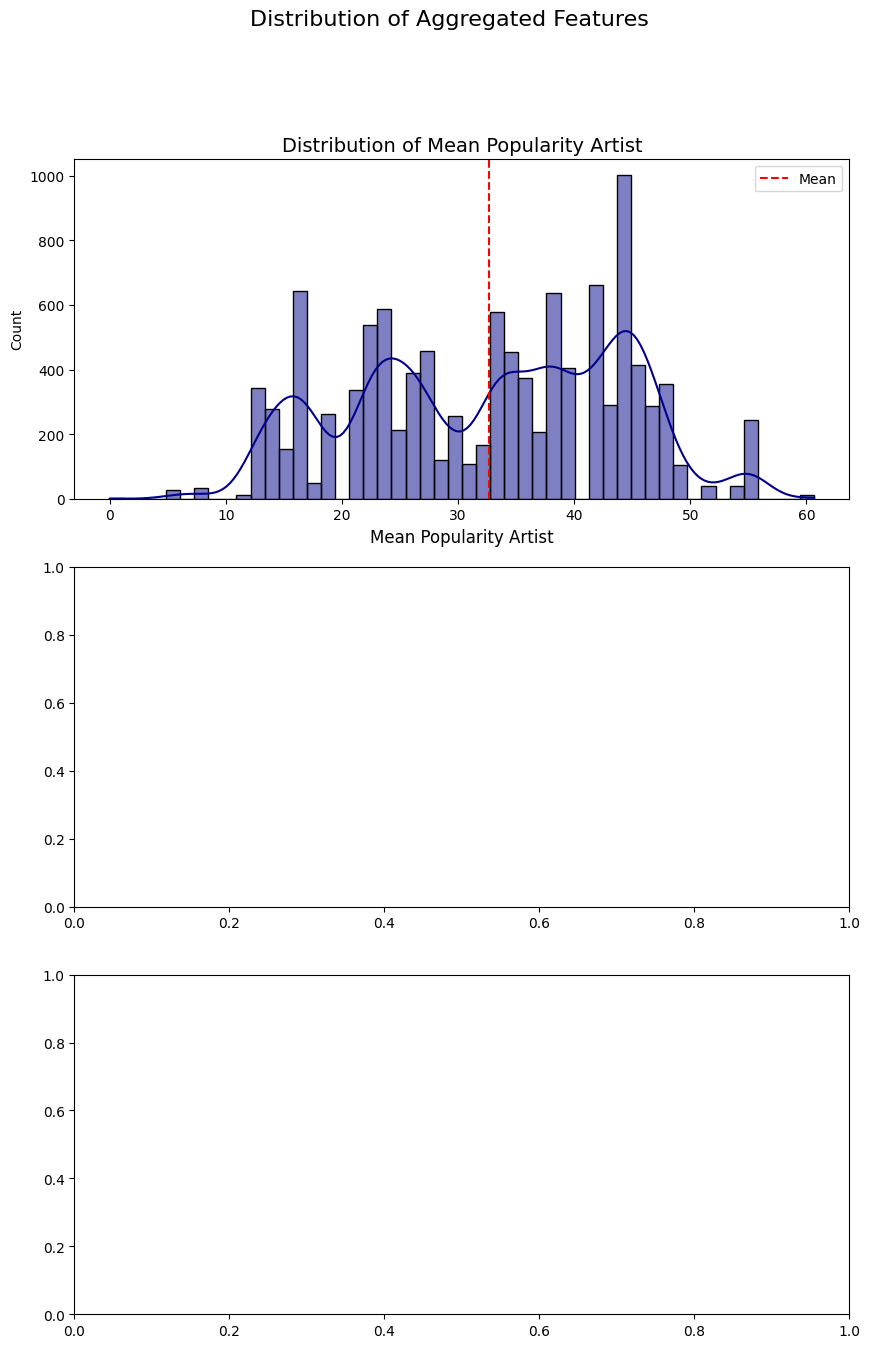

In [23]:
# Define the columns to plot
plot_cols = [
    'mean_popularity_artist', 
    'mean_popularity_album', 
    'mean_duration_song_per_album'
]

# Create a figure with 3 subplots (3 rows, 1 column)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
fig.suptitle('Distribution of Aggregated Features', fontsize=16)

# Plot each distribution
for i, col in enumerate(plot_cols):
    # Use seaborn histplot for histogram and KDE (density curve)
    sns.histplot(
        data=df, 
        x=col, 
        kde=True, 
        bins=50, 
        ax=axes[i],
        color='darkblue' if 'popularity' in col else 'darkorange'
    )
    
    # Set titles and labels
    title = col.replace('_', ' ').title()
    axes[i].set_title(f'Distribution of {title}', fontsize=14)
    axes[i].set_xlabel(title, fontsize=12)
    
    # Add a line for the overall mean of the feature
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    axes[i].legend()

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
plt.show()

## Feature track pop relative region 

In [ ]:
# --- STEP 1: Calculate the Raw Relative Popularity (without creating columns) ---

# 1. Use .transform('mean') to calculate the mean popularity for each region
#    and align it back to every row of the DataFrame.
#    This result is stored as a temporary Series, NOT a DataFrame column.
regional_avg_series = df.groupby('region')['popularity'].transform('mean')

# 2. Calculate the raw difference (also stored as a temporary Series)
raw_relative_popularity_series = df['popularity'] - regional_avg_series

# --- STEP 2: Normalize and Final Assignment ---

# 3. Instantiate the scaler
scaler = StandardScaler()

# 4. Fit/transform the temporary Series and assign the result directly to the new column
#    The result is a 2D NumPy array which is then assigned to the new DataFrame column.
df['song_pop_vs_region_avg_zscore'] = scaler.fit_transform(
    raw_relative_popularity_series.values.reshape(-1, 1)
)

# Check the new feature (only the final column is displayed)
print("\nFinal Normalized Feature Statistics:")
print(df['song_pop_vs_region_avg_zscore'].agg(['mean', 'std']))

print("\nComparison (Region and Final Z-Score):")
print(df[['name_artist', 'region', 'popularity', 'song_pop_vs_region_avg_zscore']].head())


Final Normalized Feature Statistics:
mean   -1.787979e-18
std     1.000063e+00
Name: song_pop_vs_region_avg_zscore, dtype: float64

Comparison (Region and Final Z-Score):
            name_artist    region  popularity  song_pop_vs_region_avg_zscore
id                                                                          
TR934808  rosa chemical  Piemonte          46                       0.876089
TR760029  rosa chemical  Piemonte          46                       0.876089
TR916821  rosa chemical  Piemonte          39                       0.507473
TR480968  rosa chemical  Piemonte          47                       0.928748
TR585039  rosa chemical  Piemonte          41                       0.612792


/tmp/ipykernel_11818/1744280376.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regional_avg_series = df.groupby('region')['popularity'].transform('mean')


<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_11818/2133147544.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.axvline(0, color='red', linestyle='-', linewidth=1.5, label='Mean ($\mu=0$)')
/tmp/ipykernel_11818/2133147544.py:18: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(1, color='orange', linestyle='--', linewidth=0.8, label='$\sigma$ ($\pm 1$)')
/tmp/ipykernel_11818/2133147544.py:22: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(2, color='gray', linestyle=':', linewidth=0.8, label='Outliers ($\pm 2$)')


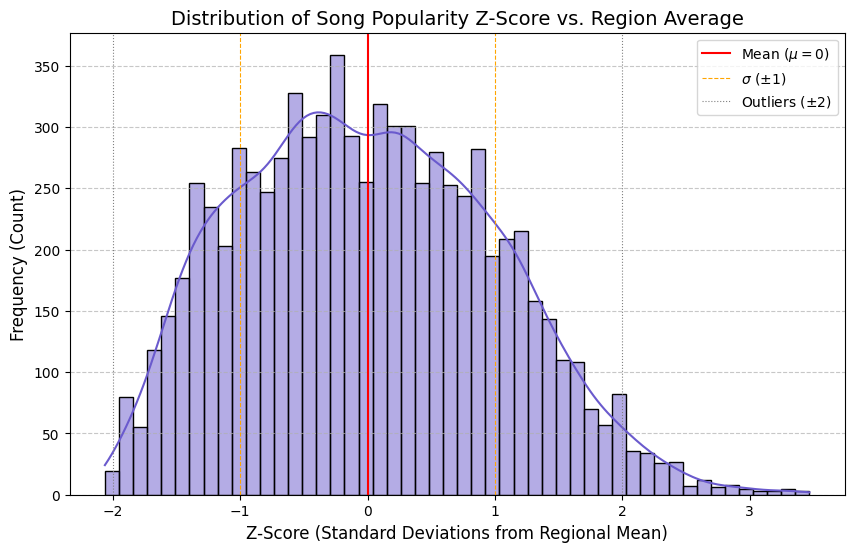

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the histogram and the smoothed KDE line
sns.histplot(
    data=df, 
    x='song_pop_vs_region_avg_zscore', 
    kde=True, 
    bins=50,  
    color='#6A5ACD' # A distinct color for the Z-score feature
)

# --- Add Reference Lines for Standard Normal Distribution ---

# Mean (expected to be near 0)
plt.axvline(0, color='red', linestyle='-', linewidth=1.5, label='Mean ($\mu=0$)')

# 1 Standard Deviation (critical for Z-score interpretation)
plt.axvline(1, color='orange', linestyle='--', linewidth=0.8, label='$\sigma$ ($\pm 1$)')
plt.axvline(-1, color='orange', linestyle='--', linewidth=0.8)

# 2 Standard Deviations (Outlier threshold)
plt.axvline(2, color='gray', linestyle=':', linewidth=0.8, label='Outliers ($\pm 2$)')
plt.axvline(-2, color='gray', linestyle=':', linewidth=0.8)


# Set the title and labels
plt.title('Distribution of Song Popularity Z-Score vs. Region Average', fontsize=14)
plt.xlabel('Z-Score (Standard Deviations from Regional Mean)', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Avg time gap artist publishes abum

In [ ]:
df = df.reset_index()

# --- STEP 1: Prepare the unique, sorted album data ---

# 1. Convert the date to a proper datetime format
# The 'errors=coerce' handles any messy non-date entries, turning them into NaT (Not a Time).

# 2. Get unique albums per artist and drop any rows where the date conversion failed
unique_releases = df[['id_artist', 'correct_release_date']].drop_duplicates().dropna(subset=['correct_release_date'])

# 3. Sort the releases chronologically WITHIN each artist group
unique_releases = unique_releases.sort_values(by=['id_artist', 'correct_release_date'])


# --- STEP 2: Calculate the time gaps (intervals) ---

# 4. Group by artist and calculate the difference between the current date and the previous one (.shift(1))
unique_releases['Previous_Date'] = unique_releases.groupby('id_artist')['correct_release_date'].shift(1)

# 5. Calculate the time difference (Timedelta object)
unique_releases['Release_Gap'] = unique_releases['correct_release_date'] - unique_releases['Previous_Date']

# 6. Convert the Timedelta object into a usable numeric value (e.g., number of days)
unique_releases['Release_Gap_Days'] = unique_releases['Release_Gap'].dt.days


# --- STEP 3: Aggregate the new feature and map it back ---

# 7. Calculate the Mean and Standard Deviation of the gaps for each artist
# The mean tells you the typical delay; the std tells you how consistent the pacing is.
artist_pacing_stats = unique_releases.groupby('id_artist')['Release_Gap_Days'].agg(
    ['mean', 'std']
).rename(columns={'mean': 'artist_avg_release_gap_days', 'std': 'artist_std_release_gap_days'})

# 8. Map the aggregated stats back to the main DataFrame
df = df.merge(
    artist_pacing_stats,
    on='id_artist',
    how='left'
)

df = df.set_index('id')

# 9. Check the new features
print("Artist's Release Pacing Features:")
print(df[['name_artist', 'correct_release_date', 'artist_avg_release_gap_days', 'artist_std_release_gap_days']].sample(10))

Artist's Release Pacing Features:
               name_artist correct_release_date  artist_avg_release_gap_days  \
id                                                                             
TR723576      rose villain           2020-07-24                   187.050000   
TR684100        emis killa           2010-10-11                   146.000000   
TR360963     achille lauro           2025-04-18                   144.393939   
TR191523     willie peyote           2014-06-24                   283.560000   
TR149109        clementino           2012-01-01                   369.181818   
TR568955      mondo marcio           2008-07-11                   177.173913   
TR281798  massimo pericolo           2019-09-27                   226.769231   
TR169398             lazza           2014-12-29                   104.021739   
TR300576       fabri fibra           2004-09-01                   284.433333   
TR594615          tony boy           2021-12-21                   115.519231   

     

/tmp/ipykernel_11818/3027671353.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_releases['Previous_Date'] = unique_releases.groupby('id_artist')['correct_release_date'].shift(1)
/tmp/ipykernel_11818/3027671353.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  artist_pacing_stats = unique_releases.groupby('id_artist')['Release_Gap_Days'].agg(


In [ ]:
# Assuming your previous steps (1 through 7) ran successfully, 
# you have the following DataFrames:
# - unique_releases (Contains individual 'Release_Gap_Days')
# - artist_pacing_stats (Contains 'artist_avg_release_gap_days' and 'artist_std_release_gap_days')
df = df.reset_index()

# 1. Merge the aggregated stats back into the individual release gaps
# We need the mean and std alongside the individual gap (X) to calculate Z.
unique_releases = unique_releases.merge(
    artist_pacing_stats,
    on='id_artist',
    how='left'
)

# 2. CALCULATE THE Z-SCORE
# Z = (Individual Gap - Artist Mean Gap) / Artist Standard Deviation
unique_releases['release_gap_zscore'] = (
    (unique_releases['Release_Gap_Days'] - unique_releases['artist_avg_release_gap_days']) / 
    unique_releases['artist_std_release_gap_days']
)

# 3. Aggregate the new Z-Score feature

# We cannot simply merge the Z-score column from unique_releases back into df 
# because there are multiple tracks per album and multiple albums per artist.

# The most meaningful Z-score is the one calculated on the individual album gap.
# We map the Z-score back to the main DataFrame by creating a unique key:
# (id_artist, correct_release_date).

# Prepare Z-score for merge (key is the index)
zscore_to_merge = unique_releases.set_index(['id_artist', 'correct_release_date'])[
    'release_gap_zscore'
].reset_index()


# 4. Map the Z-Score back to the main DataFrame
# We now match on the unique (id_artist, correct_release_date) pair to get the correct Z-score for that album.
df = df.merge(
    zscore_to_merge,
    on=['id_artist', 'correct_release_date'],
    how='left'
)

df = df.set_index('id')

# 5. Clean up and check the new feature

# Cleanup (remove intermediate date columns)
df.drop(columns = ['artist_avg_release_gap_days', 'artist_std_release_gap_days'], inplace = True)
# Ensure the original 'artist_avg_release_gap_days' and 'artist_std_release_gap_days' 
# are kept if you want them; otherwise, they can be removed too.

print("Release Gap Z-Score Feature Added:")
print(df[['name_artist', 'correct_release_date', 'release_gap_zscore']].sample(10))

Release Gap Z-Score Feature Added:
            name_artist correct_release_date  release_gap_zscore
id                                                              
TR857902          shiva                  NaT                 NaN
TR113376  bassi maestro           1998-08-01            1.588521
TR657976    noyz narcos           2007-01-01            0.435713
TR229788      sottotono           2021-12-03           -0.489365
TR903244            gue           2025-06-05           -0.303085
TR335107         madman                  NaT                 NaN
TR386183  achille lauro           2017-12-15            1.915811
TR787970  sfera ebbasta           2025-04-10            1.153379
TR294253      dani faiv           2023-12-15            0.976666
TR611849          nesli           2023-03-10            2.156264


In [ ]:
print(df[['name_artist', 'correct_release_date', 'release_gap_zscore']].sample(10))

            name_artist correct_release_date  release_gap_zscore
id                                                              
TR278505        mahmood           2021-06-10           -0.391693
TR435253          vacca           2017-01-26           -0.712279
TR703993        geolier           2018-10-18           -0.286070
TR519117      doll kill           2022-10-28            1.749419
TR231225   mondo marcio           2006-01-01            1.618137
TR835111         piotta           2002-06-20            0.359388
TR307610  dargen damico           2024-02-02           -0.544141
TR389084    noyz narcos           2005-01-01                 NaN
TR665206            jax           2016-05-20           -0.434556
TR338477       gemitaiz           2018-03-30           -0.421166


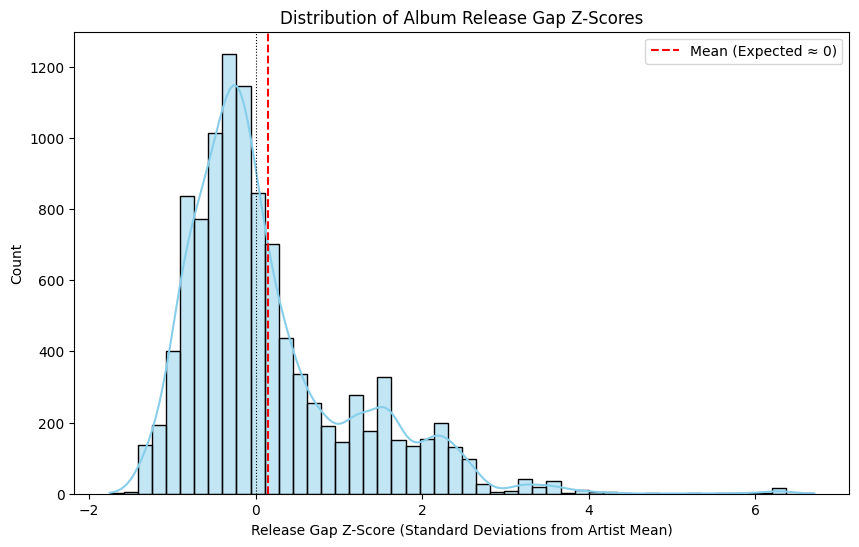

In [ ]:
plt.figure(figsize=(10, 6))
# Plot the histogram (bars) and the smoothed KDE line
sns.histplot(
    data=df,
    x='release_gap_zscore',
    kde=True,
    bins=50,  # Use more bins for smoother visualization
    color='skyblue'
)

# Add standard normal distribution lines for reference
plt.axvline(df['release_gap_zscore'].mean(), color='red', linestyle='--', label='Mean (Expected ≈ 0)')
plt.axvline(0, color='black', linestyle=':', linewidth=0.8)

plt.title('Distribution of Album Release Gap Z-Scores')
plt.xlabel('Release Gap Z-Score (Standard Deviations from Artist Mean)')
plt.legend()
plt.show()

## words Per Minute (WPM)

In [ ]:
# 1. Calculate the estimated Total Characters (the numerator)
# This serves as the proxy for total syllables delivered.
total_tokens = df['n_tokens']

# 2. Calculate the Duration in Minutes (easier for division)
duration_minutes = df['duration_ms'] / 60000

# 3. Calculate the Final Characters Per Minute (CPM)
# Note: This is mathematically equivalent to your single-line formula.
# We calculate it this way to improve readability and avoid potential syntax errors.
df['tokens_per_minute'] = total_tokens / duration_minutes

# Check the new feature
print(df[['name_artist', 'title', 'n_tokens', 'duration_ms', 'tokens_per_minute']].head())

            name_artist         title  n_tokens  duration_ms  \
id                                                             
TR934808  rosa chemical  ​polka 2 :-/       911     207761.0   
TR760029  rosa chemical         POLKA       675     207761.0   
TR916821  rosa chemical  ​britney ;-)       758     193544.0   
TR480968  rosa chemical           CEO       382     169000.0   
TR585039  rosa chemical        LONDRA       429     194779.0   

          tokens_per_minute  
id                           
TR934808         263.090763  
TR760029         194.935527  
TR916821         234.985326  
TR480968         135.621302  
TR585039          132.14977  


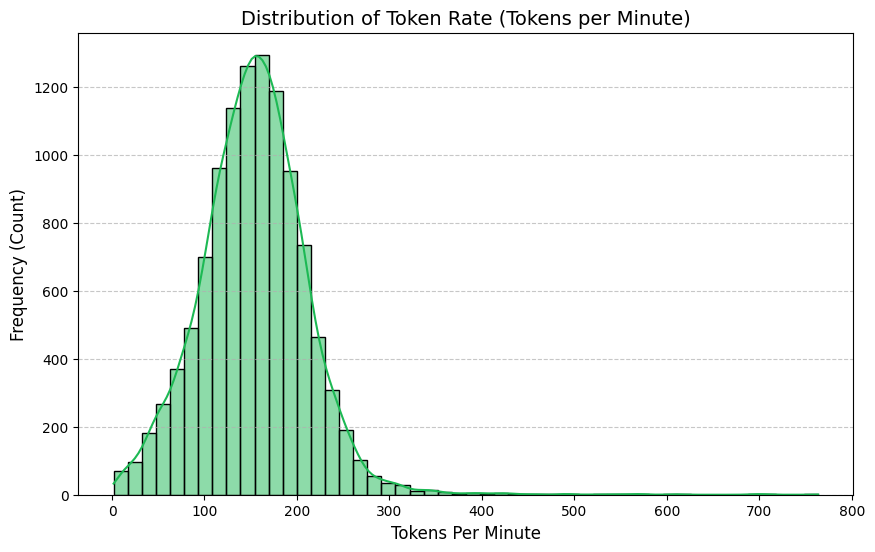

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the histogram and the smoothed KDE line
sns.histplot(
    data=df, 
    x='tokens_per_minute', 
    kde=True, 
    bins=50,  # Use more bins for better granularity
    color='#1DB954' # Spotify Green color
)

# Set the title and labels
plt.title('Distribution of Token Rate (Tokens per Minute)', fontsize=14)
plt.xlabel('Tokens Per Minute', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)

# Optional: Set a reasonable X-axis limit to filter out extreme outliers 
# which can skew the visual representation of the main distribution.
# This line attempts to set the limit around the 99.5th percentile.
try:
    x_limit = df['tokens_per_minute']
    plt.xlim(left=0, right=x_limit)
except:
    pass # Use default limits if quantile calculation fails

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Swear Word Rate

In [ ]:
# Calculate Swear Word Rate (normalized by total words)
# This calculation avoids creating a persistent 'Total_Swears' column in df.
df['swear_rate'] = np.where(
    # Condition: Ensure n_tokens is not null AND greater than zero to prevent division by zero
    df['n_tokens'].notna() & (df['n_tokens'] > 0),

    # Value if True: Calculate the ratio (swear_IT + swear_EN) / n_tokens
    (df['swear_IT'] + df['swear_EN']) / df['n_tokens'],

    # Value if False: Set rate to 0 (no words to swear with)
    0
)

# Display the new feature and its components (for verification only)
print(df[['name_artist', 'title', 'swear_IT', 'swear_EN', 'n_tokens', 'swear_rate']].head())

            name_artist         title  swear_IT  swear_EN  n_tokens  \
id                                                                    
TR934808  rosa chemical  ​polka 2 :-/        13         6       911   
TR760029  rosa chemical         POLKA         9        12       675   
TR916821  rosa chemical  ​britney ;-)        16        12       758   
TR480968  rosa chemical           CEO         8         3       382   
TR585039  rosa chemical        LONDRA         1         0       429   

          swear_rate  
id                    
TR934808    0.020856  
TR760029    0.031111  
TR916821    0.036939  
TR480968    0.028796  
TR585039    0.002331  


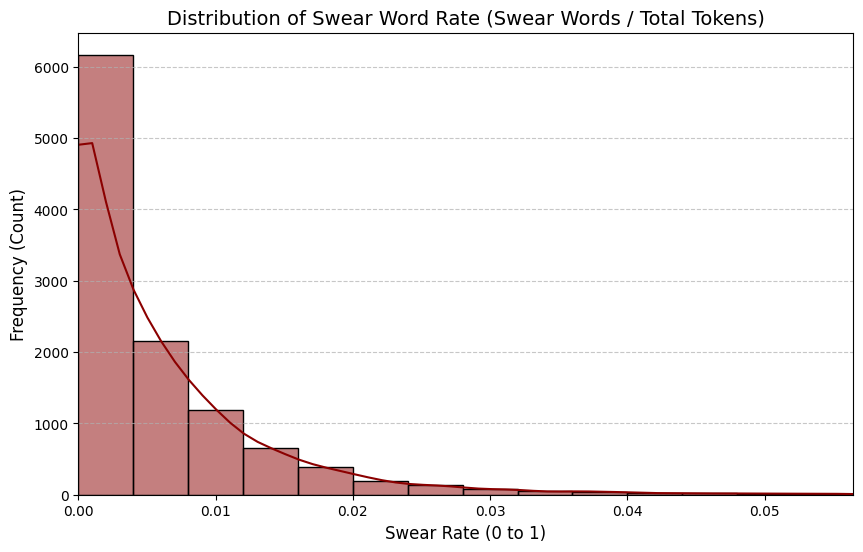

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the histogram and the smoothed KDE line
sns.histplot(
    data=df, 
    x='swear_rate', 
    kde=True, 
    bins=50,  # Use a sufficient number of bins for resolution
    color='darkred'
)

# Set the title and labels
plt.title('Distribution of Swear Word Rate (Swear Words / Total Tokens)', fontsize=14)
plt.xlabel('Swear Rate (0 to 1)', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)

# Set X-axis limits to clearly show the concentration at 0 and the rare high rates
# The swear rate cannot exceed 1.0
try:
    x_limit = df['swear_rate'].quantile(0.995) * 1.1
    plt.xlim(left=0, right=x_limit)
except:
    pass # Use default limits if quantile calculation fails

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Rank song based on popularity of the year 


In [ ]:
# 1. Calculate the Rank_by_Year directly.
# The year extraction (pd.to_datetime(...).dt.year) creates a temporary Series
# that is used as the grouping key but is NOT assigned as a permanent column to df.
df['rank_by_year'] = (
    df.groupby(pd.to_datetime(df['correct_release_date'], errors='coerce').dt.year)['popularity']
    .rank(method='dense', ascending=False)
)

# 2. Verification Check (Requires temporary Year for filtering in the print statement)
# Create a temporary Series 'temp_year' for the filter condition only
temp_year = pd.to_datetime(df['correct_release_date'], errors='coerce').dt.year

print("Top 5 Tracks Ranked by Popularity in a Specific Year (Example - using year 2020):")
print(df[temp_year == 2020]
      [['name_artist', 'title', 'correct_release_date', 'popularity', 'rank_by_year']]
      .sort_values(by='rank_by_year', ascending=True)
      .head(5)
)

Top 5 Tracks Ranked by Popularity in a Specific Year (Example - using year 2020):
         name_artist                     title correct_release_date  \
id                                                                    
TR350878      thasup                  No Sleep           2020-03-20   
TR164391    highsnob                 Bad Bitch           2020-10-16   
TR492509    tony boy                   War RMX           2020-03-21   
TR436288    highsnob  Per odiarti non ho tempo           2020-10-16   
TR301319      piotta        Su di me (Outtake)           2020-10-30   

          popularity  rank_by_year  
id                                  
TR350878          91           1.0  
TR164391          85           2.0  
TR492509          84           3.0  
TR436288          82           4.0  
TR301319          79           5.0  


In [ ]:
# 1. Recalculate the temporary Year Series for filtering (necessary for filtering)
temp_year = pd.to_datetime(df['correct_release_date'], errors='coerce').dt.year

# 2. Identify the last 10 unique, non-null years present in the data
last_10_years = temp_year.dropna().unique()
# Sort the years in descending order and select the first 20
last_10_years = np.sort(last_10_years)[::-1][:20]


# 3. Loop through the last 10 years and print the top 5 ranked tracks
print("\n--- Top 5 Tracks Ranked by Popularity (Last 20 Years) ---")
print("-----------------------------------------------------------------")

for year in last_10_years:
    # Filter the DataFrame for the current year
    yearly_df = df[temp_year == year].copy()

    # Sort and display the top 5 tracks for the current year
    top_5 = yearly_df[
        ['name_artist', 'title', 'popularity', 'rank_by_year']
    ].sort_values(by='rank_by_year', ascending=True).head(5)

    if not top_5.empty:
        print(f"\n🏆 YEAR: {int(year)}")
        print(top_5.to_string(index=False))


--- Top 5 Tracks Ranked by Popularity (Last 20 Years) ---
-----------------------------------------------------------------

🏆 YEAR: 2025
name_artist            title  popularity  rank_by_year
rondodasosa          MY LIFE          97           1.0
      fedez          My Life          97           1.0
     thasup Coraline In Love          97           1.0
    babaman       First Love          95           2.0
      fedez      I’m So High          94           3.0

🏆 YEAR: 2024
name_artist                           title  popularity  rank_by_year
   tony boy                   Tutto a posto          78           1.0
  marracash                     Fotoromanzo          75           2.0
  marracash Promo Sky NBA 2016/17 Freestyle          75           2.0
  marracash                          Regole          75           2.0
      lazza                         Candida          75           2.0

🏆 YEAR: 2023
  name_artist             title  popularity  rank_by_year
        luche Estate dimm

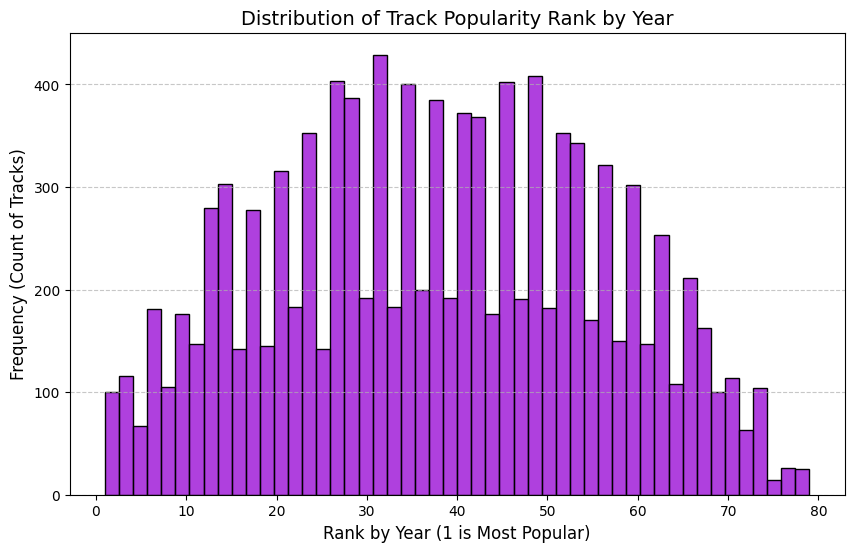

In [ ]:
plt.figure(figsize=(10, 6))

# Use seaborn histplot for visualization. We treat the rank as discrete data
# and let the bins parameter handle the discrete nature of the ranks.
sns.histplot(
    data=df, 
    x='rank_by_year', 
    kde=False,  # KDE is less meaningful for ranks
    bins=50,    # Use a high number of bins to clearly separate ranks
    color='darkviolet'
)

# Set the title and labels
plt.title('Distribution of Track Popularity Rank by Year', fontsize=14)
plt.xlabel('Rank by Year (1 is Most Popular)', fontsize=12)
plt.ylabel('Frequency (Count of Tracks)', fontsize=12)

# Optional: Limit the view to the most common ranks (e.g., ranks 1-1000)
# This prevents the plot from being stretched by very high, rare ranks.
try:
    x_limit = df['rank_by_year'].quantile(0.995) * 1.1
    plt.xlim(left=0, right=x_limit)
except:
    pass # Use default limits if quantile calculation fails

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Create the new boolean column 'has_featured_artist'
df['has_featured_artist'] = df['featured_artists'].apply(lambda x: len(x) > 0)

# The result is True if the list length is greater than 0 (i.e., not empty).

/tmp/ipykernel_11818/3076858843.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


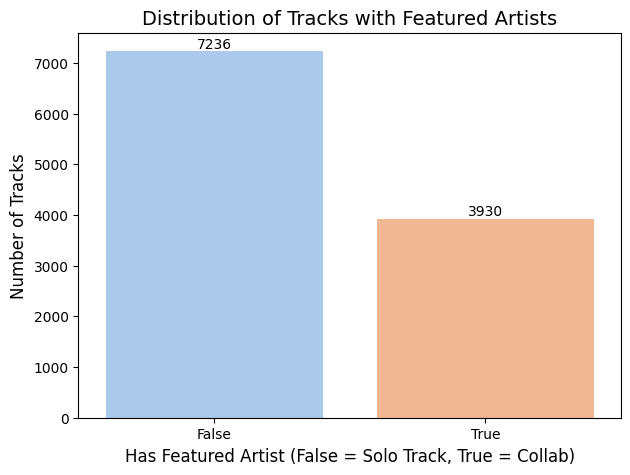

In [ ]:
plt.figure(figsize=(7, 5))

# Create a count plot for the new boolean column
sns.countplot(
    x='has_featured_artist', 
    data=df, 
    palette='pastel',
    order=[False, True] # Ensure a consistent order
)

plt.title('Distribution of Tracks with Featured Artists', fontsize=14)
plt.xlabel('Has Featured Artist (False = Solo Track, True = Collab)', fontsize=12)
plt.ylabel('Number of Tracks', fontsize=12)

# Optional: Add data labels on top of the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       fontsize=10, color='black', 
                       xytext=(0, 5), 
                       textcoords='offset points')

plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11166 entries, TR934808 to TR552777
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id_artist                      11166 non-null  category      
 1   name_artist                    11166 non-null  string        
 2   title                          11166 non-null  string        
 3   featured_artists               11166 non-null  object        
 4   language                       11032 non-null  category      
 5   swear_IT                       11166 non-null  int64         
 6   swear_EN                       11166 non-null  int64         
 7   swear_IT_words                 11166 non-null  object        
 8   swear_EN_words                 11166 non-null  object        
 9   n_sentences                    10959 non-null  Int64         
 10  n_tokens                       10955 non-null  Int64         
 11  tokens_per

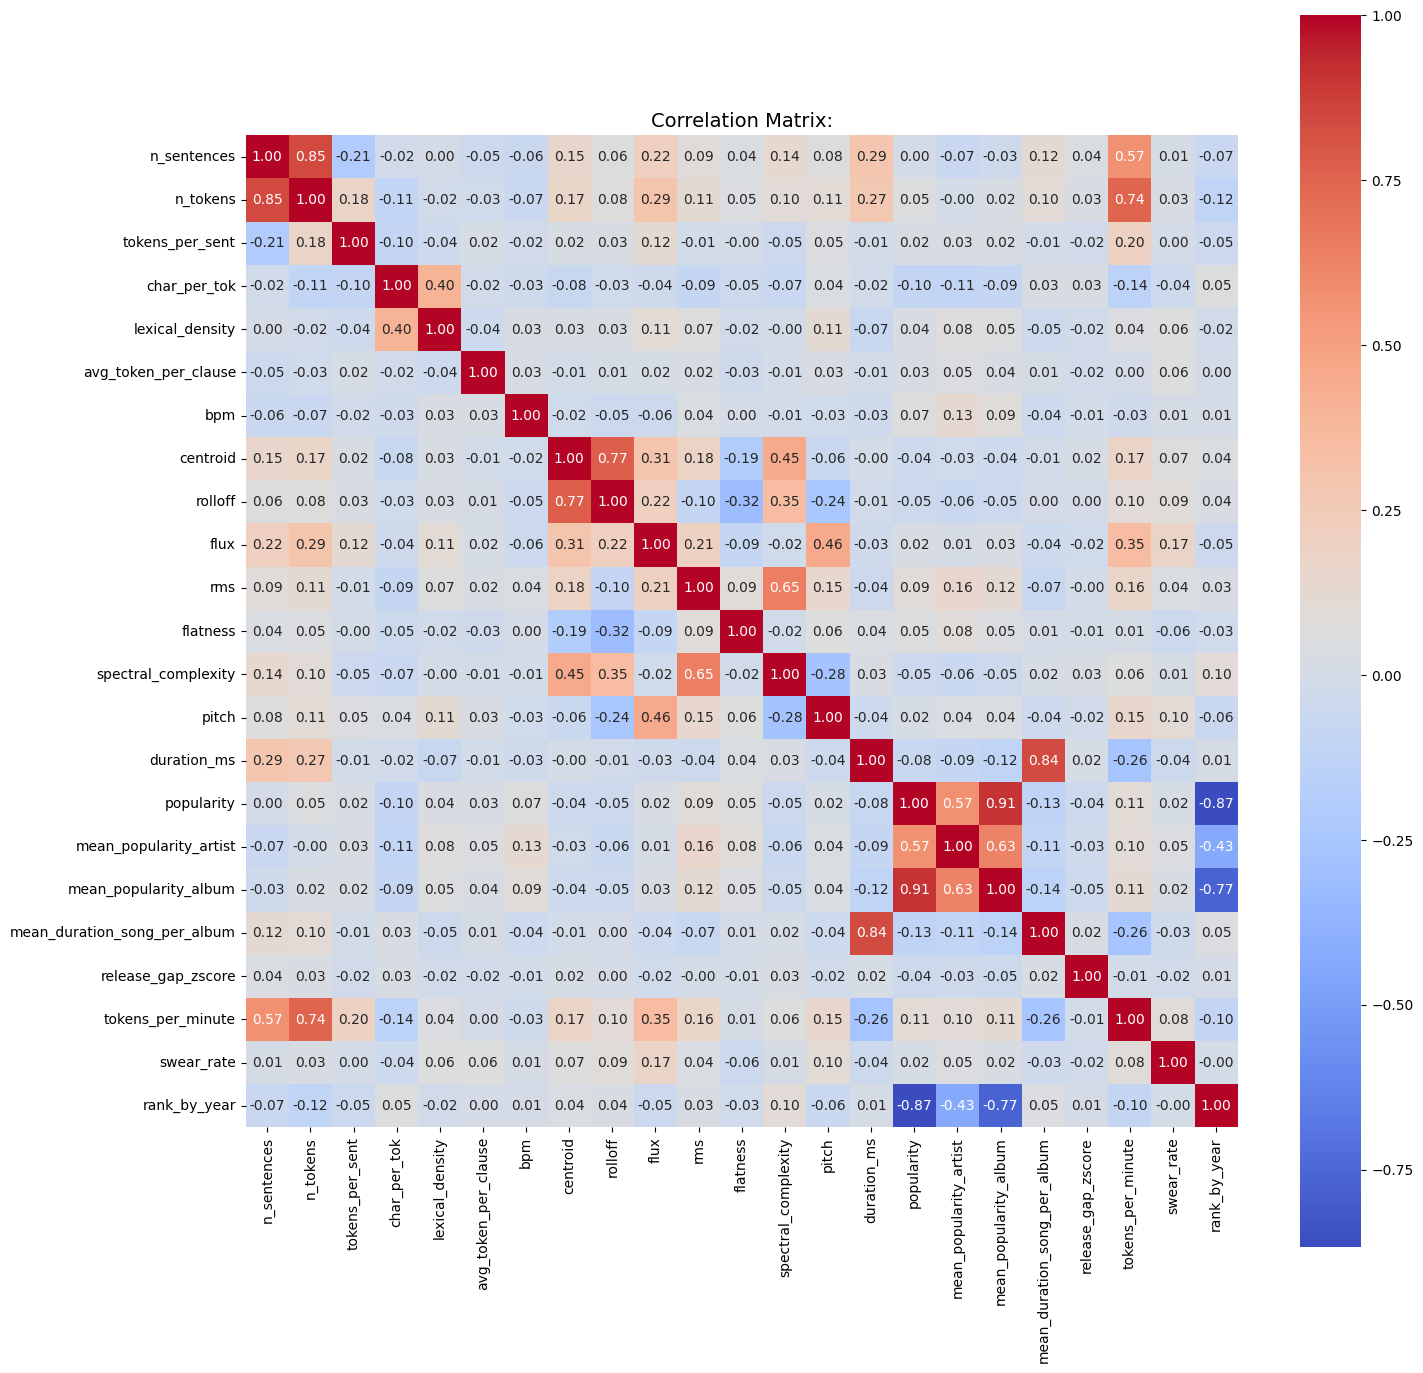

In [ ]:
# 1. Define the list of meaningful numeric columns you want to plot
features = [
    'n_sentences',
    'n_tokens',
    'tokens_per_sent',
    'char_per_tok',
    'lexical_density',
    'avg_token_per_clause',
    'bpm',
    'centroid',
    'rolloff',
    'flux',
    'rms',
    'flatness',
    'spectral_complexity',
    'pitch',
    'duration_ms',
    'popularity',
    'mean_popularity_artist',
    'mean_popularity_album',
    'mean_duration_song_per_album',
    'release_gap_zscore',
    'tokens_per_minute',
    'swear_rate',
    'rank_by_year'
]

# 2. Select the subset of data
df_subset = df[features]

# 3. Calculate the correlation matrix on the subset
corr_matrix_subset = df_subset.corr()

# 4. Plot the results
plt.figure(figsize=(16, 16)) # Use a smaller figure size for fewer columns
sns.heatmap(corr_matrix_subset, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix:", fontsize=14)
plt.show()

In [ ]:
df.to_csv('dataset/df_data_engineered.csv', index = True)